In [1]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [11]:
from functools import partial
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from anomaly.reconstruction import ReconstructionAnomalyScore
from anomaly.utils import FilterParameters, ReconstructionParameters
from astroExplain.spectra.explainer import LimeSpectraExplainer
from astroExplain.spectra.segment import SpectraSegmentation
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory
from anomaly.utils import specobjid_to_idx
from anomaly.utils import set_intersection
from astroExplain.spectra.utils import get_anomaly_score_name

meta = MetaData()
%matplotlib inline

In [3]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"
scores_directory = f"{meta_data_directory}/bin_04/explanation/256_128_64/latent_12"

In [4]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")

In [9]:
# anomaly score
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": False,
    "kernel_size": 3,
    "sigma": 0
}

# load data frame with anomalies
anomaly_from_score = get_anomaly_score_name(
    metric=score_config["metric"],
    velocity=score_config["velocity"],
    relative=score_config["relative"],
    percentage=score_config["percentage"]
)

anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)

specobjid = anomalies_df.index[-14]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]


anomaly = ReconstructionAnomalyScore(
    # reconstruct_function
    model.reconstruct,
    filter_parameters=FilterParameters(
        wave=wave,
        lines=score_config["lines"],
        velocity_filter=score_config["velocity"]
    ),
    reconstruction_parameters=ReconstructionParameters(
        percentage=score_config["percentage"],
        relative=score_config["relative"],
        epsilon=score_config["epsilon"]
    )
)

anomaly_score_function = partial(
    anomaly.score, metric=score_config["metric"]
)
# Set explainer instance
print(f"Set explainer and Get explanations", end="\n")
explainer = LimeSpectraExplainer(random_state=0)

if lime_config["segmentation"] == "kmeans":
    
    segmentation_fn = SpectraSegmentation().kmeans

elif lime_config["segmentation"] == "uniform":

    segmentation_fn = SpectraSegmentation().uniform


segmentation_fn = partial(
    segmentation_fn, number_segments=lime_config["number_segments"]
)
# Load galaxy
# Compute anomaly score
# convert spectrum to gray image
spectrum = spectrum[np.newaxis, :]

Set explainer and Get explanations


In [20]:
# Get explanations
n_samples = [10, 100, 1_000, 5_000, 10_000]
speed = []
for n in n_samples:
    lime_config["number_samples"] = n

    t_start = time.perf_counter()
    explanation = explainer.explain_instance(
        spectrum=spectrum,
        classifier_fn=anomaly_score_function,
        segmentation_fn=segmentation_fn,
        fudge_parameters = fudge_config,
        explainer_parameters = lime_config,
    )
    t_finish = time.perf_counter()
    speed.append(t_finish-t_start)
    print(f"{t_finish-t_start:.4f}")

0.0614
0.1100
0.8205
4.2336
8.3995


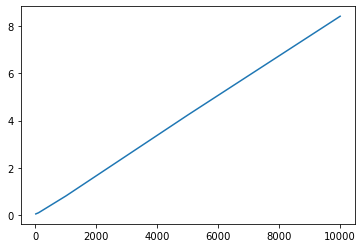

In [21]:
plt.plot(n_samples, speed)

In [22]:
# Get explanations
t_start = time.perf_counter()
reconstruction  = model.reconstruct(spectrum)
t_finish = time.perf_counter()
print(f"{t_finish-t_start:.4f}")

0.0445
